# Unemployment Rate Forecasting

#### Arhum Zafar - December 2020

This notebook consists of another attempt to look into building accurate forecasting models for economic indicators -- specifically, I’ll be looking into forecasting the unemployment rate. 
<br>
<br>
In practice, traditional time series forecasting, such as [autoregressive moving average (ARMA)](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model) models can lead to unsatisfactory results. 
In this notebook, I use 3 months of data to predict the unemployment rate for the following month. With the decision to use linear regression as a baseline model, I then compare performance from a [random forest model](https://towardsdatascience.com/understanding-random-forest-58381e0602d2?gi=749dace27dd5), [XGBoost](https://en.wikipedia.org/wiki/XGBoost) , and [long short-term memory (LSTM)](https://en.wikipedia.org/wiki/Long_short-term_memory). Furthermore, I use both mean squared error (MSE) and mean absolute error (MAE) as evaluation metrics.


## Table of Contents
1. [Data Preprocessing](#data)
2. [Feature Importance](#feat)
3. [Baseline Model](#base)
4. [Machine Learning Models](#ml)
    - [Linear Regression](#lr)
    - [Random Forest](#rf)
    - [XGBoost](#xg)
5. [ARIMA](#arima)
    

#### Import Dependencies

In [6]:
import warnings
warnings.filterwarnings(action='ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Preprocessing and EDA <a name="data"></a>

In [7]:
predictor = pd.read_csv("Econ_predictors.csv")
predictor.head()

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
0,1/1/1959,2437.296,2288.8,17.302,292258.8329,18235.77392,22.6250,23.4581,22.1904,32.4078,...,11.358,2.13,2.45,2.04,NaN,274.9,6476.0,12298.0,84.2043,NaN
1,2/1/1959,2446.902,2297.0,17.482,294429.5453,18369.56308,23.0681,23.7747,22.3827,32.6455,...,11.375,2.14,2.46,2.05,NaN,276.0,6476.0,12298.0,83.5280,NaN
2,3/1/1959,2462.689,2314.0,17.647,293425.3813,18523.05762,23.4004,23.9186,22.4925,32.6455,...,11.395,2.15,2.45,2.07,NaN,277.4,6508.0,12349.0,81.6405,NaN
3,4/1/1959,2478.744,2330.3,17.584,299331.6505,18534.46600,23.8989,24.2641,22.8221,33.1606,...,11.436,2.16,2.47,2.08,NaN,278.1,6620.0,12484.0,81.8099,NaN
4,5/1/1959,2493.228,2345.8,17.796,301372.9597,18679.66354,24.2589,24.4655,23.0418,33.3190,...,11.454,2.17,2.48,2.08,95.3,280.1,6753.0,12646.0,80.7315,NaN


In [8]:
predictor.describe()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
count,739.00000,739.000000,739.000000,7.380000e+02,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,...,739.000000,740.000000,740.000000,740.000000,585.000000,740.000000,739.000000,739.000000,740.000000,698.000000
mean,8405.87536,7222.200812,59.811617,8.221857e+05,192800.909746,67.413487,70.406355,68.526970,79.549975,74.530444,...,55.005954,11.634824,13.522784,10.783405,86.541026,4327.767162,116241.919134,317191.071028,1060.116141,19.173294
std,4275.40255,3441.142743,31.142736,3.767955e+05,154862.772384,27.172953,27.395076,27.294157,24.090859,32.408684,...,34.125128,7.010684,7.804571,6.370632,12.430932,4836.483278,114723.436639,318370.073679,1087.461794,7.405686
min,2437.29600,2288.800000,17.302000,2.809267e+05,18235.773920,22.625000,23.458100,22.190400,32.407800,20.112600,...,11.358000,2.130000,2.450000,2.040000,51.700000,274.900000,6476.000000,12298.000000,71.186400,8.016400
25%,4772.31800,4254.150000,32.306500,5.059602e+05,46773.572588,44.992200,46.197175,44.280425,61.824950,47.650075,...,19.748000,4.657500,6.215000,4.287500,77.200000,598.800000,10577.500000,32649.000000,168.365275,14.090250
50%,7682.72900,6722.000000,53.899000,7.454158e+05,154854.213700,63.449400,70.386350,68.076750,81.294800,67.850400,...,53.057000,11.150000,13.125000,10.435000,90.200000,2094.700000,70279.000000,176753.210000,564.696750,17.535400
75%,12101.49200,10357.200000,90.416500,1.167988e+06,331928.250000,95.117750,99.047225,97.071375,102.330975,108.472575,...,83.774000,17.472500,19.362500,16.445000,95.300000,6658.750000,246069.190000,703427.345000,1837.948450,22.472800
max,19121.72400,14328.100000,121.894000,1.535612e+06,537526.000000,110.551600,111.023800,108.641400,114.249000,125.766600,...,120.063000,25.490000,29.430000,22.820000,112.000000,21128.200000,343472.980000,896985.060000,4363.668100,67.151000


In [9]:
predictor.sasdate = pd.to_datetime(predictors.sasdate, infer_datetime_format=True)

NameError: name 'predictors' is not defined

There seems to be missing values in August 2020 -- let's drop it.
<br>
<br>
Now let's get a visual on how the unemployment rate changes over time.

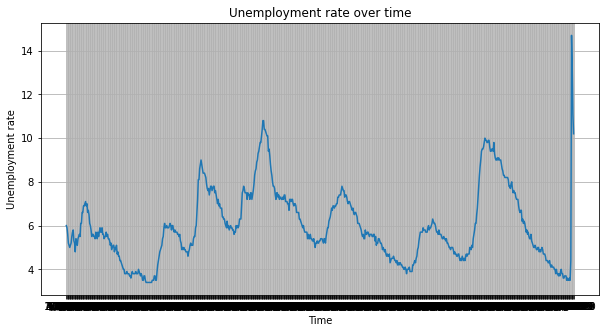

In [10]:
predictor = predictor[:-1]

plt.figure(figsize=(10,5))
plt.plot(predictor.sasdate, predictor.UNRATE)
plt.xlabel("Time")
plt.ylabel("Unemployment rate")
plt.title("Unemployment rate over time")
plt.grid()

In [11]:
# Let's seperate the data create indexes based on different criteria.

gp0_date_idx = [0] 
gp1_income_idx = [1, 2] + [i for i in range(6, 20)]
gp2_labor_market_idx = [i for i in range(20, 48)] + [120, 121, 122]
gp3_housing_idx = [i for i in range(48, 58)]
gp4_consumption_idx = [3, 4, 5] + [i for i in range(58, 64)] + [123]
gp5_money_idx = [i for i in range(64, 74)] +  [124, 125, 126, 127]
gp6_interest_idx = [i for i in range(78, 100)]
gp7_price_idx = [i for i in range(100, 119)]
gp8_stock_idx = [74, 75, 76, 77] + [128]

date = predictor.columns[gp0_date_idx]
gp1_income = predictor.columns[gp1_income_idx]
gp2_labor_market = predictor.columns[gp2_labor_market_idx]
gp3_housing = predictor.columns[gp3_housing_idx]
gp4_consumption = predictor.columns[gp4_consumption_idx]
gp5_money = predictor.columns[gp5_money_idx]
gp6_interest = predictor.columns[gp6_interest_idx]
gp7_price = predictor.columns[gp7_price_idx]
gp8_stock = predictor.columns[gp8_stock_idx]

target = "UNRATE"

In [12]:
# There shouldn't be anymore NA values.

gp2 = predictor[gp2_labor_market]
gp2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739 entries, 0 to 738
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   HWI            739 non-null    float64
 1   HWIURATIO      739 non-null    float64
 2   CLF16OV        739 non-null    int64  
 3   CE16OV         739 non-null    int64  
 4   UNRATE         739 non-null    float64
 5   UEMPMEAN       739 non-null    float64
 6   UEMPLT5        739 non-null    int64  
 7   UEMP5TO14      739 non-null    int64  
 8   UEMP15OV       739 non-null    int64  
 9   UEMP15T26      739 non-null    int64  
 10  UEMP27OV       739 non-null    int64  
 11  CLAIMSx        739 non-null    int64  
 12  PAYEMS         739 non-null    int64  
 13  USGOOD         739 non-null    int64  
 14  CES1021000001  739 non-null    float64
 15  USCONS         739 non-null    int64  
 16  MANEMP         739 non-null    int64  
 17  DMANEMP        739 non-null    int64  
 18  NDMANEMP  

In [13]:
# Function to correlation heatmap
def corr_heatmap(x, annotate = False, font_size = 12, figsize = (10,10)):
    x_corr_mat = x.corr()
    f, ax = plt.subplots(figsize=figsize) 
    heatmap = sns.heatmap(x_corr_mat, 
                          square = True,
                          linewidths = .5,
                          cmap = 'coolwarm',
                          cbar_kws = {'shrink': .4, 'ticks' : [-1, -0.5, 0, 0.5, 1]},
                          annot = annotate,
                          vmin = -1, 
                          vmax = 1,
                          annot_kws = {"size": font_size})

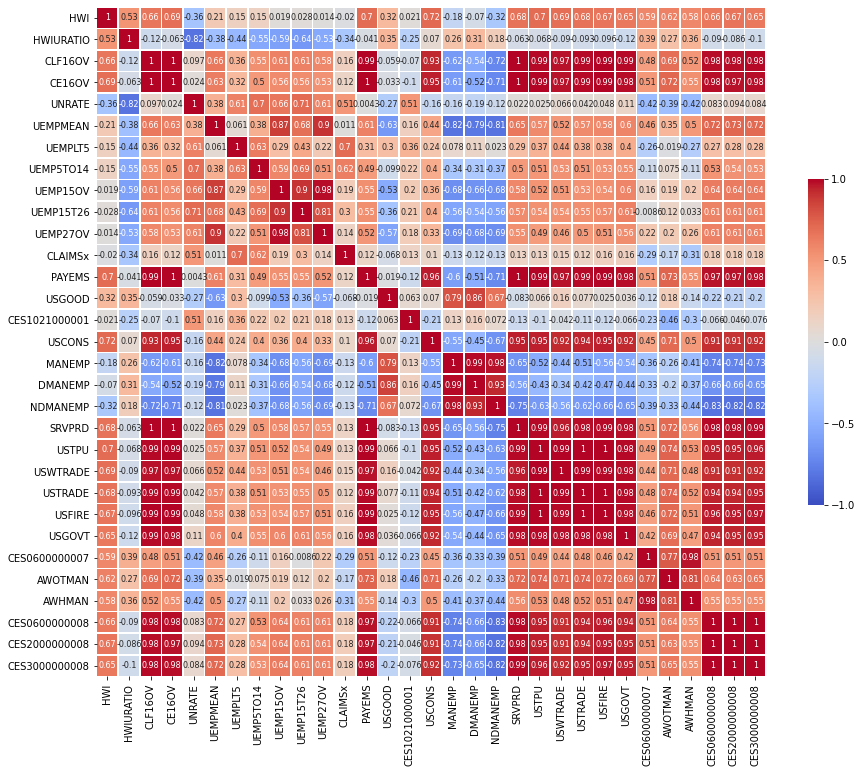

In [14]:
corr_heatmap(gp2, True, 8, figsize=(15,15))

When looking above, there are a number of variables with high correlation with **UNRATE** (the unemployment rate), such as **"CES10210{5}1", "HWIURATIO", "UNEMPMEAN", "CLAIMSx"**.

#### Group 1: No missing values

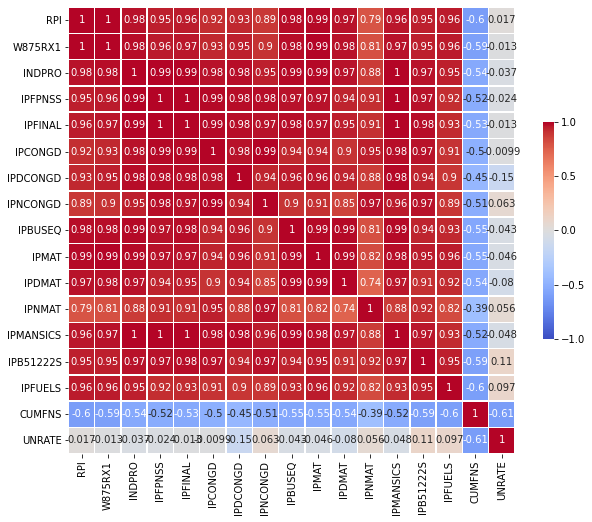

In [15]:
gp1 = predictor[gp1_income]
corr_heatmap(pd.concat([gp1, predictor["UNRATE"]], axis = 1), True, 10)

Above, only variable has relatively high correlation with the unemployment rate: **CUMFNS**.

#### Group 3

In [16]:
gp3 = predictor[gp3_housing]
gp3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739 entries, 0 to 738
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   HOUST     739 non-null    int64  
 1   HOUSTNE   739 non-null    int64  
 2   HOUSTMW   739 non-null    int64  
 3   HOUSTS    739 non-null    int64  
 4   HOUSTW    739 non-null    int64  
 5   PERMIT    727 non-null    float64
 6   PERMITNE  727 non-null    float64
 7   PERMITMW  727 non-null    float64
 8   PERMITS   727 non-null    float64
 9   PERMITW   727 non-null    float64
dtypes: float64(5), int64(5)
memory usage: 57.9 KB


In [17]:
predictor[date][gp3.isnull().any(axis = 1)]

,sasdate
0,1/1/1959
1,2/1/1959
2,3/1/1959
3,4/1/1959
4,5/1/1959
5,6/1/1959
6,7/1/1959
7,8/1/1959
8,9/1/1959
9,10/1/1959


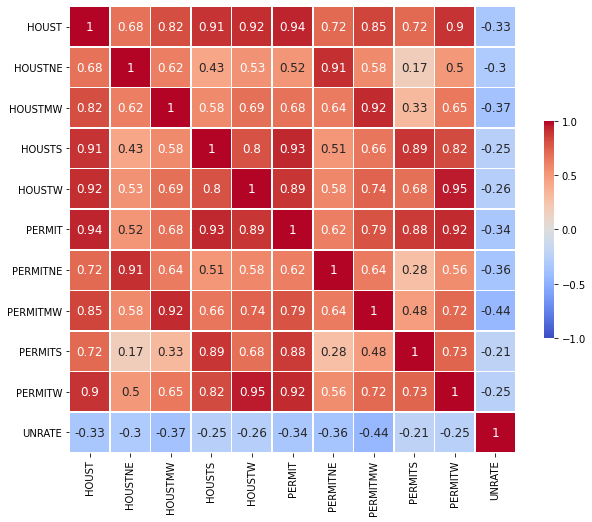

In [18]:
# Remove the first 12 rows, correspond the data in 1959.
gp3 = gp3[12:]
corr_heatmap(pd.concat([gp3, predictor["UNRATE"][12:]], axis = 1), True)

Above, nothing is super correlated.

#### Group 4

In [19]:
gp4 = predictor[gp4_consumption]
gp4.describe()

,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,ACOGNO,AMDMNOx,ANDENOx,AMDMUOx,BUSINVx,ISRATIOx,UMCSENTx
count,739.000000,7.380000e+02,739.000000,342.000000,739.000000,630.000000,7.390000e+02,7.390000e+02,739.000000,585.000000
mean,59.811617,8.221857e+05,192334.434658,154561.324561,119882.612368,44243.681237,4.596442e+05,8.249313e+05,1.477014,86.541026
std,31.142736,3.767955e+05,154446.538967,40405.095950,77208.768803,24143.298096,3.499728e+05,5.869584e+05,0.120633,12.430932
min,17.302000,2.809267e+05,18235.773920,86445.000000,13253.957810,6010.041362,3.937935e+04,8.488956e+04,1.240000,51.700000
25%,32.306500,5.059602e+05,46682.564845,117187.000000,40663.372045,24008.990615,1.538396e+05,2.479176e+05,1.390000,77.200000
50%,53.899000,7.454158e+05,154840.731100,155884.000000,114846.315600,44076.550190,4.303110e+05,7.919941e+05,1.498013,90.200000
75%,90.416500,1.167988e+06,331613.000000,191783.000000,187932.000000,65650.000000,5.618635e+05,1.265264e+06,1.570331,95.300000
max,121.894000,1.535612e+06,534558.000000,215709.000000,292371.000000,131973.000000,1.171856e+06,2.033707e+06,1.756291,112.000000


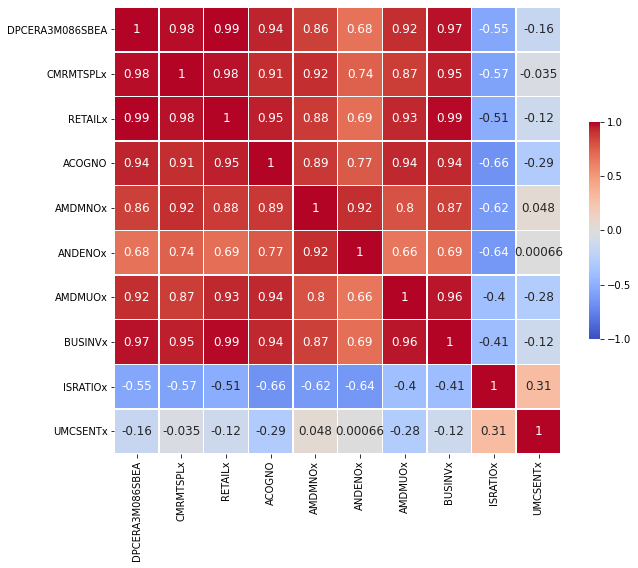

In [20]:
gp4_drop_rows = gp4.dropna()
corr_heatmap(gp4_drop_rows, True, 12)

Above, we see that **ACOGNO** (Adjusted Consumer Goods New Orders) is correlated to other predictors, let's remove it. Additionally, **UMCSENTx** is not highly correlated to the other columns so let's keep it for now.

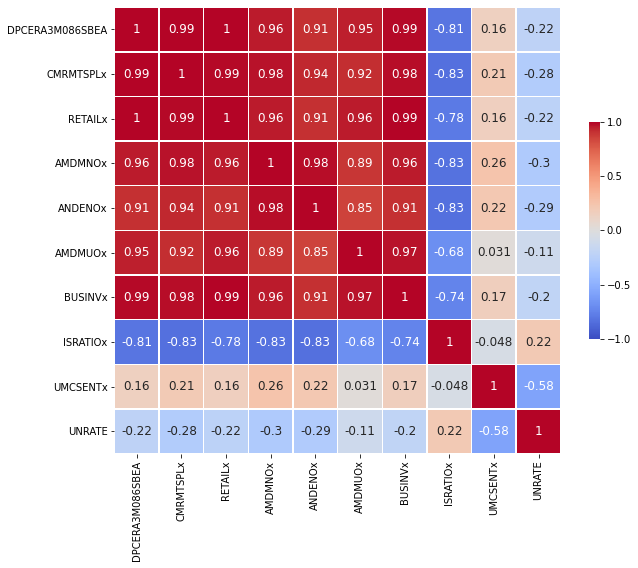

In [21]:
gp4_test1 = gp4.drop(['ACOGNO'], axis = 1)
gp4_test1 = gp4_test1.dropna()
corr_heatmap(gp4_test1.join(predictor["UNRATE"]), True)

Above, **UMNCSENTx** has a strong negative correlation. If we look closer at **UMNSCENTx** and find missing values, we should impute them so we can keep this feature.

#### Group 5

In [22]:
gp5 = predictor[gp5_money]
gp5.info()
#Check for missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739 entries, 0 to 738
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   M1SL         739 non-null    float64
 1   M2SL         739 non-null    float64
 2   M2REAL       739 non-null    float64
 3   BOGMBASE     739 non-null    int64  
 4   TOTRESNS     739 non-null    float64
 5   NONBORRES    739 non-null    int64  
 6   BUSLOANS     739 non-null    float64
 7   REALLN       739 non-null    float64
 8   NONREVSL     739 non-null    float64
 9   CONSPI       739 non-null    float64
 10  MZMSL        739 non-null    float64
 11  DTCOLNVHFNM  739 non-null    float64
 12  DTCTHFNM     739 non-null    float64
 13  INVEST       739 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 81.0 KB


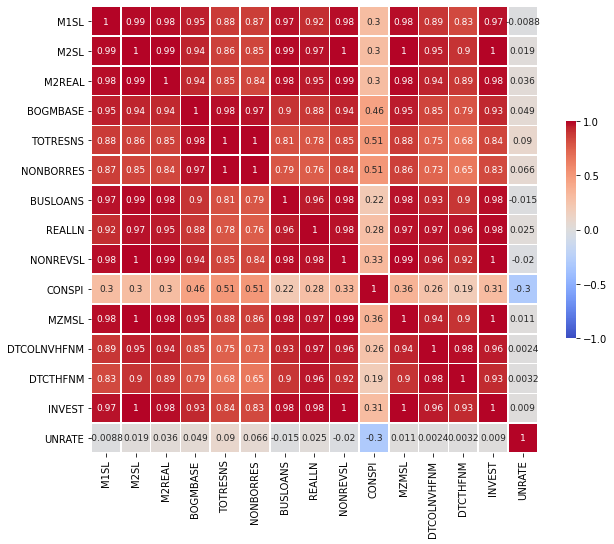

In [23]:
corr_heatmap(gp5.join(predictor["UNRATE"]), True, 9)

Nothing super correlated here.

#### Group 6

In [24]:
gp6 = predictor[gp6_interest]
gp6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739 entries, 0 to 738
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FEDFUNDS       739 non-null    float64
 1   CP3Mx          738 non-null    float64
 2   TB3MS          739 non-null    float64
 3   TB6MS          739 non-null    float64
 4   GS1            739 non-null    float64
 5   GS5            739 non-null    float64
 6   GS10           739 non-null    float64
 7   AAA            739 non-null    float64
 8   BAA            739 non-null    float64
 9   COMPAPFFx      738 non-null    float64
 10  TB3SMFFM       739 non-null    float64
 11  TB6SMFFM       739 non-null    float64
 12  T1YFFM         739 non-null    float64
 13  T5YFFM         739 non-null    float64
 14  T10YFFM        739 non-null    float64
 15  AAAFFM         739 non-null    float64
 16  BAAFFM         739 non-null    float64
 17  TWEXAFEGSMTHx  571 non-null    float64
 18  EXSZUSx   

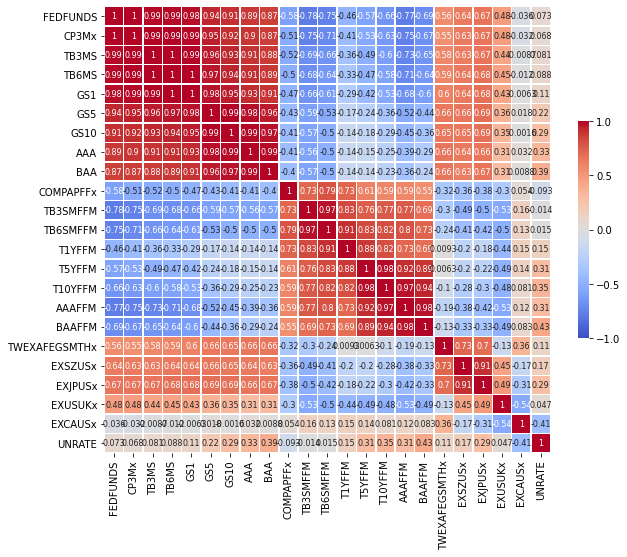

In [25]:
gp6_test1 = gp6.dropna()
corr_heatmap(gp6_test1.join(predictor["UNRATE"]), True, 8)

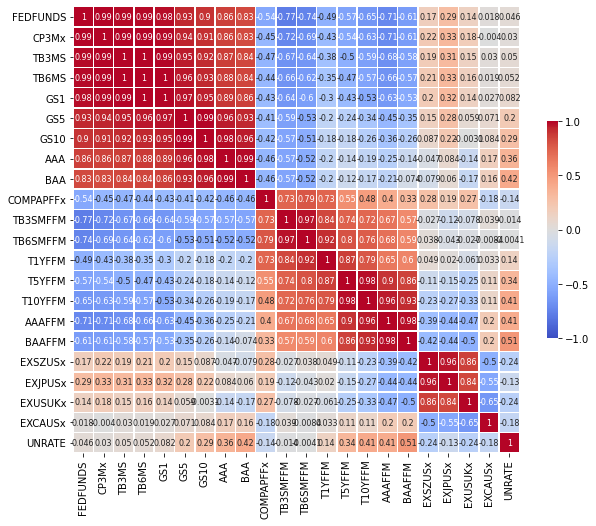

In [26]:
gp6_test2 = gp6.drop("TWEXAFEGSMTHx", axis = 1).dropna()
corr_heatmap(gp6_test2.join(predictor["UNRATE"]), True, 8)

In the above 2 heatmaps, I saw a big correlation in **TWEXAFEGSMTHx** to the predictors in the first heatmap, so I removed it. 
<br>
<br>
In the second heatmap, there's a high correlation between **BAAFFM** and the unemployment rate.

#### Group 7

In [27]:
gp7 = predictor[gp7_price]
gp7.describe()

,WPSFD49207,WPSFD49502,WPSID61,WPSID62,OILPRICEx,PPICMM,CPIAUCSL,CPIAPPSL,CPITRNSL,CPIMEDSL,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA
count,739.000000,739.000000,739.000000,739.000000,739.000000,739.000000,739.000000,739.000000,739.000000,739.000000,739.000000,739.000000,739.000000,739.000000,739.000000,739.000000,739.000000,739.000000,739.000000
mean,111.066847,113.338024,108.286604,110.646820,30.082899,118.404465,127.900966,99.661101,115.213346,193.162273,111.298191,90.302080,144.034823,127.789537,123.857103,124.618103,59.259484,98.773556,57.968261
std,56.829077,60.490447,57.173908,66.227017,28.051203,64.972009,75.293306,31.372384,63.638639,154.851810,54.359535,32.685418,97.247849,75.316735,69.437431,71.447041,31.241879,27.411023,28.170088
min,33.000000,33.100000,30.400000,29.000000,2.920000,32.200000,28.970000,44.700000,29.300000,21.100000,33.200000,37.800000,22.900000,28.900000,30.700000,29.600000,16.074000,56.570000,17.777000
25%,51.300000,51.900000,51.050000,60.200000,10.110000,69.650000,48.800000,68.950000,45.600000,41.750000,52.900000,50.650000,43.300000,47.450000,50.900000,49.250000,26.060000,70.179000,29.545500
50%,114.600000,113.100000,112.500000,100.900000,20.342000,108.500000,125.400000,118.100000,115.400000,152.800000,117.800000,106.700000,133.700000,125.200000,122.900000,123.800000,61.281000,101.519000,60.217000
75%,153.200000,157.200000,150.050000,161.600000,39.890000,159.650000,192.750000,125.889500,168.451500,319.050000,157.850000,114.500000,227.450000,193.400000,182.950000,186.250000,85.914500,122.140500,80.671500
max,207.800000,220.100000,204.700000,303.400000,133.930000,322.100000,259.050000,135.100000,223.274000,523.255000,189.884000,129.700000,332.370000,258.624000,236.582000,246.917000,111.146000,140.457000,101.390000


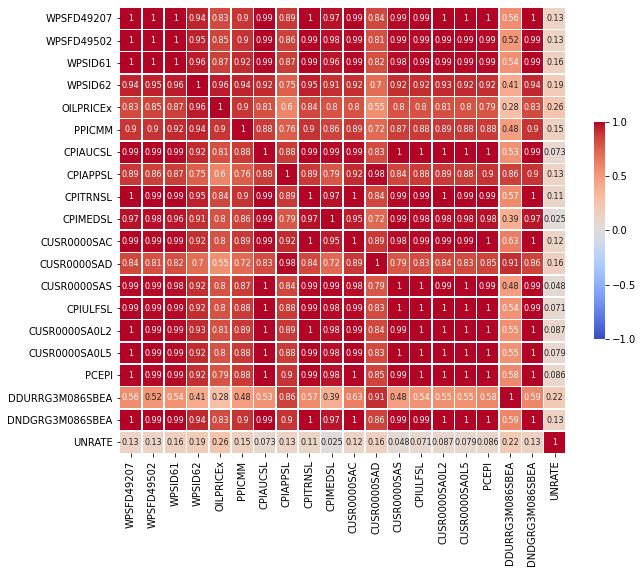

In [28]:
corr_heatmap(gp7.join(predictor["UNRATE"]), True, 8)

No correlation here.

#### Group 8

In [29]:
gp8 = predictor[gp8_stock]
gp8.describe()

,S&P 500,S&P: indust,S&P div yield,S&P PE ratio,VXOCLSx
count,739.000000,739.000000,738.000000,739.000000,697.000000
mean,707.996171,886.062368,2.925673,18.915917,19.171709
std,774.131260,1030.192071,1.116089,8.242171,7.410886
min,53.730000,56.900000,1.108074,6.569558,8.016400
25%,99.350000,109.650000,1.958140,14.610263,14.086700
50%,328.750000,381.110000,2.933357,18.444449,17.513800
75%,1198.105000,1421.945000,3.523942,21.795339,22.474400
max,3278.200000,4536.380000,6.237048,86.843117,67.151000


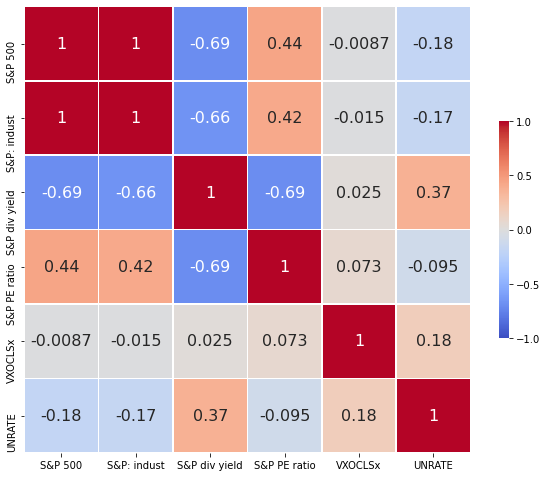

In [30]:
corr_heatmap(gp8.dropna().join(predictor["UNRATE"]), True, 16)

Drop the **VXOCLSx**, which has lots of missing values.


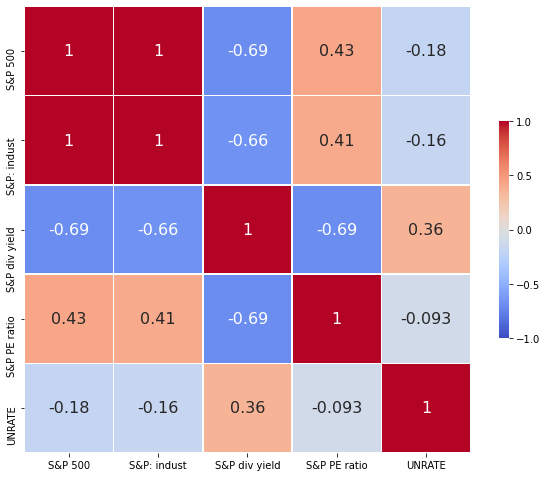

In [31]:
corr_heatmap(gp8.drop("VXOCLSx", axis = 1).dropna().join(predictor["UNRATE"]), True, 16)

Not much here. It's a given that using features that are derived off the stock market aren't a reliable thing to do. I actually wrote a report on this [which you can find here](https://github.com/arhumzafar/PredictingStocks/blob/master/Group%20Report%20-%20STAT%20453.pdf)
<br>
<br>
After looking at correlation for several features in the above heatmaps, my intial selection of features are: **CUMFNS, BAAFFM, CLAIMSx, HWIURATIO, UEMPLT5, UEMP5TO14, UEMP15OV, UEMP15T26, UEMP27OV, CES1021000001**.

In [32]:
feature_test1 = predictor[["UNRATE", "CUMFNS", "BAAFFM", "CES1021000001", "CLAIMSx", "HWIURATIO", 
                           "UEMPLT5", "UEMP5TO14", "UEMP15OV", "UEMP15T26", "UEMP27OV"]].dropna()


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fee15aa9a90>,
      dtype=object)

<Figure size 1440x720 with 0 Axes>

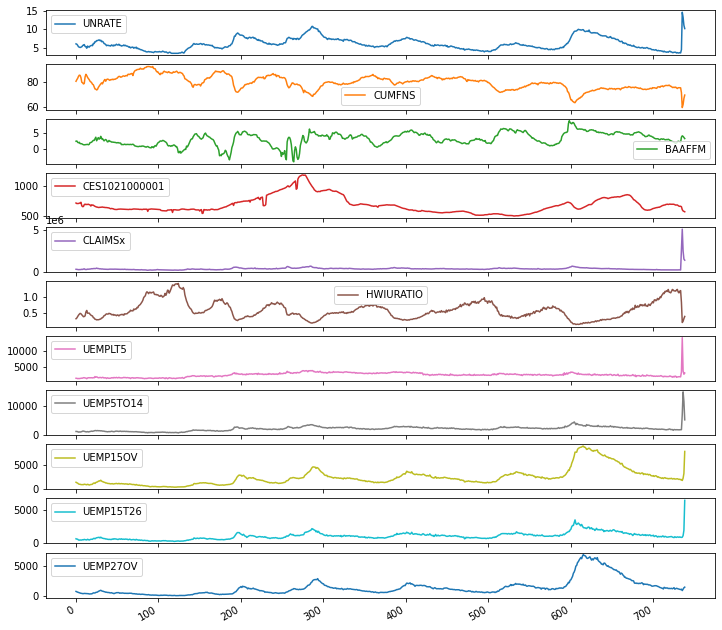

In [33]:
plt.figure(figsize=(20,10))
# plt.plot(feature_test1)
feature_test1.plot(subplots = True, figsize = (12,12))

### Feature Importance <a name="feat"></a>

In [49]:
from sklearn.model_selection import train_test_split

def explore_feats(train_df, test_df = None, input_width = 1, label_width = 1, shift = 1, topK = 10):
    wg = Window_generator(input_width, label_width=label_width, shift=shift)
    wg.fit(train_df)
    x_train, y_train, col_names = wg.transform(train_df)
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
    rf.fit(x_train, y_train)
    df_importance = pd.DataFrame(rf.feature_importances_, index = col_names)
    df_importance_sorted = df_importance.sort_values(by = 0, ascending = False)
    plt.plot(df_importance_sorted.index[:topK], df_importance_sorted[:topK], marker = ".")
    plt.xlabel("Feature name")
    plt.ylabel("Feature importance")
    plt.xticks(rotation = 315)
    return df_importance_sorted[:topK]

In [50]:
data_feature_test_1 = data_2020_removed[corr_featrues]
train_df, test_df = train_test_split(data_feature_test_1, test_size = 0.2, shuffle = False)

##### Create Time Window

In [39]:
data_2020_removed = predictor[:-7]

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin
############# CITATION

class Window_generator(BaseEstimator, TransformerMixin):
    def __init__(self, input_window_length, label_width = 1, shift = 1, label_columns = ["UNRATE"]):
        self.input_window_length = input_window_length
        self.label_width = label_width
        self.shift = shift
        self.label_columns = label_columns
        self.total_window_length = input_window_length + label_width + shift - 1
        
        
    def fit(self, X, y=None):
        self.X = X
        self.start_indices = [i for i in range(X.shape[0] - self.total_window_length + 1)]  
        self.end_indices = [i + self.input_window_length - 1 for i in self.start_indices]
        self.label_start = [i + self.input_window_length + self.shift - 1 for i in self.start_indices]
        self.label_end = [i + self.total_window_length - 1 for i in self.start_indices]
        self.columns = X.columns
        return self
    
    def _get_windows_indices(self):
        input_indices = []
        label_indices = []
        for i in range(len(self.start_indices)):
            input_indices.append(np.arange(self.input_window_length) + i)
            label_indices.append(np.arange(self.label_start[i], self.label_end[i] + 1))
        return (np.array(input_indices), np.array(label_indices))
    
    def create_window_data(self):
        input_indices, label_indices = self._get_windows_indices()
        labels = self.X[self.label_columns]
        return self.X.values[input_indices], labels.values[label_indices]
    
    def transform(self, X, y=None):
        input_window, label_window = self.create_window_data()
        input_flatten = input_window.reshape(input_window.shape[0], -1)
        label_flatten = label_window.reshape(label_window.shape[0], -1)
        orig_column_list = self.columns.tolist()
        # Returns the column names in the following format: "Col_name_{n}m", meaning the feature at n month ago
        column_names = ["{}_{}m".format(i, j + self.shift) for j in range(self.input_window_length - 1, -1, -1) for i in orig_column_list]
        return input_flatten, label_flatten, column_names
        
    def __repr__(self):
        return '\n'.join([
            f'start_indices: {self.start_indices}',
            f'end_indices: {self.end_indices}',
            f'label_start: {self.label_start}',
            f'label_end: {self.label_end}'])

### Baseline Model <a name="base"></a>

Here, we'll create a baseline model and use all the features given, just to see where that takes us.

In [41]:
baseline1_dataset = predictor.dropna()

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [43]:
df_base1 = data_2020_removed.dropna(axis = 1).drop("sasdate", axis = 1)
df_train, df_test = train_test_split(df_base1, test_size = 0.2, shuffle = False)
scaler = StandardScaler()
scaler.fit(df_train.values)
df_train_scaled = pd.DataFrame(scaler.transform(df_train.values), columns=df_train.columns)
df_test_scaled = pd.DataFrame(scaler.transform(df_test.values), columns=df_test.columns)

wg = Window_generator(3,1)
x_train, y_train, col_names = wg.fit_transform(df_train_scaled)
x_test, y_test, _ = wg.fit_transform(df_test_scaled)

In [44]:
y_std = df_train["UNRATE"].std()
y_mean = df_train["UNRATE"].mean()

Train mse: 0.020959864310245067
Test mse: 0.09402145074790974
Train mae: 0.11198763299437545
Test mae: 0.24577608956129854


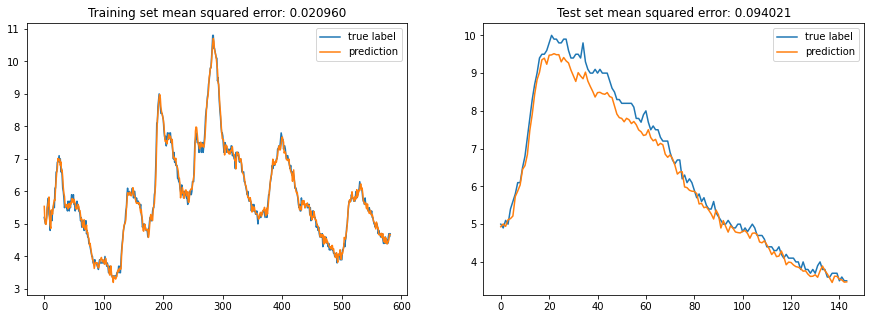

In [51]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
test_prediction = lin_reg.predict(x_test) *y_std + y_mean
test_mse = mean_squared_error(test_prediction, y_test * y_std + y_mean)
train_prediction = lin_reg.predict(x_train) * y_std + y_mean
train_mse = mean_squared_error(train_prediction , y_train * y_std + y_mean)
print("Train mse:", train_mse)
print("Test mse:", test_mse)
test_mae = mean_absolute_error(test_prediction, y_test * y_std + y_mean)
train_mae = mean_absolute_error(train_prediction , y_train * y_std + y_mean)
print("Train mae:", train_mae)
print("Test mae:", test_mae)
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(y_train * y_std + y_mean, label = "true label")
axes[0].plot(train_prediction, label = "prediction")
axes[0].legend()
axes[0].set_title("Training set mean squared error: %f" % train_mse)
axes[1].plot(y_test * y_std + y_mean, label = "true label")
axes[1].plot(test_prediction, label = "prediction")
axes[1].legend()
axes[1].set_title("Test set mean squared error: %f" % test_mse)
plt.show()

Above, we didn't do a great job predicting the true labels -- let's look at feature importance.

                     value
UEMP27OV_1m       8.512587
UEMP15T26_1m      5.747873
UEMP15OV_2m       5.479114
UEMP15OV_3m       5.417568
UNRATE_1m         0.628288
UNRATE_2m         0.230937
CES1021000001_2m  0.146855
CLAIMSx_1m        0.115280
HWIURATIO_3m      0.110827
UNRATE_3m         0.088769


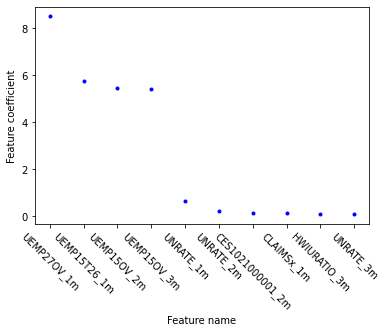

In [52]:
feature_coefs = pd.DataFrame(lin_reg.coef_.T, index=col_names, columns=["value"]).sort_values(by = "value", ascending=False)
print(feature_coefs[:10])
plt.plot(feature_coefs[:10], "b.")
plt.xlabel("Feature name")
plt.ylabel("Feature coefficient")
plt.xticks(rotation = 315)
plt.show()

### Machine Learning Models <a name="ml"></a>

#### Linear Regression <a name="lr"></a>

Below, we'll do a linear regression with the 11 features I listed above, excluding the 2020 data.

In [53]:
def fit_LR_forecast(x_train, y_train, y_mean, y_std):
    lin_reg = LinearRegression()
    lin_reg.fit(x_train, y_train)
    test_prediction = lin_reg.predict(x_test) * y_std + y_mean
    test_mse = mean_squared_error(test_prediction, y_test * y_std + y_mean)
    train_prediction = lin_reg.predict(x_train) * y_std + y_mean
    train_mse = mean_squared_error(train_prediction , y_train * y_std + y_mean)
    print("Train mse:", train_mse)
    print("Test mse:", test_mse)
    test_mae = mean_absolute_error(test_prediction, y_test * y_std + y_mean)
    train_mae = mean_absolute_error(train_prediction , y_train * y_std + y_mean)
    print("Train mae:", train_mae)
    print("Test mae:", test_mae)
    fig, axes = plt.subplots(1,2, figsize=(15,5))
    axes[0].plot(y_train * y_std + y_mean, label = "true label")
    axes[0].plot(train_prediction, label = "prediction")
    axes[0].legend()
    axes[0].set_title("Training set mean squared error: %f" % train_mse)
    axes[1].plot(y_test * y_std + y_mean, label = "true label")
    axes[1].plot(test_prediction, label = "prediction")
    axes[1].legend()
    axes[1].set_title("Test set mean squared error: %f" % test_mse)
    plt.show()

In [54]:
corr_featrues = ["CUMFNS", "BAAFFM", "CES1021000001", "CLAIMSx", "HWIURATIO", "UEMPLT5", "UEMP5TO14", "UEMP15OV", "UEMP15T26", "UEMP27OV", "UNRATE"]
df_base2 = data_2020_removed[corr_featrues].dropna()
df_train, df_test = train_test_split(df_base2, test_size = 0.2, shuffle = False)
scaler.fit(df_train.values)
df_train_scaled = pd.DataFrame(scaler.transform(df_train.values), columns=df_train.columns)
df_test_scaled = pd.DataFrame(scaler.transform(df_test.values), columns=df_test.columns)

wg = Window_generator(3,1)
x_train, y_train, col_names = wg.fit_transform(df_train_scaled)
x_test, y_test, _ = wg.fit_transform(df_test_scaled)
y_std = df_train["UNRATE"].std()
y_mean = df_train["UNRATE"].mean()

Train mse: 0.020959864310245067
Test mse: 0.09402145074790974
Train mae: 0.11198763299437545
Test mae: 0.24577608956129854


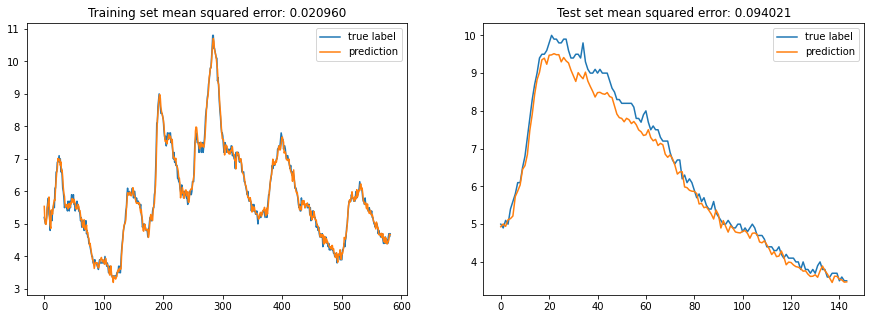

In [55]:
fit_LR_forecast(x_train, y_train, y_mean, y_std)

#### Linear Regression with 1 feature -- 2020 excluded.

In [56]:
df_base1 = data_2020_removed[["UNRATE"]]
df_train, df_test = train_test_split(df_base1, test_size = 0.2, shuffle = False)
scaler = StandardScaler()
scaler.fit(df_train.values)
df_train_scaled = pd.DataFrame(scaler.transform(df_train.values), columns=df_train.columns)
df_test_scaled = pd.DataFrame(scaler.transform(df_test.values), columns=df_test.columns)

wg = Window_generator(3,1)
x_train, y_train, col_names = wg.fit_transform(df_train_scaled)
x_test, y_test, _ = wg.fit_transform(df_test_scaled)

Train mse: 0.029477487101737157
Test mse: 0.027828645234036792
Train mae: 0.12981764464889542
Test mae: 0.1303614443295445


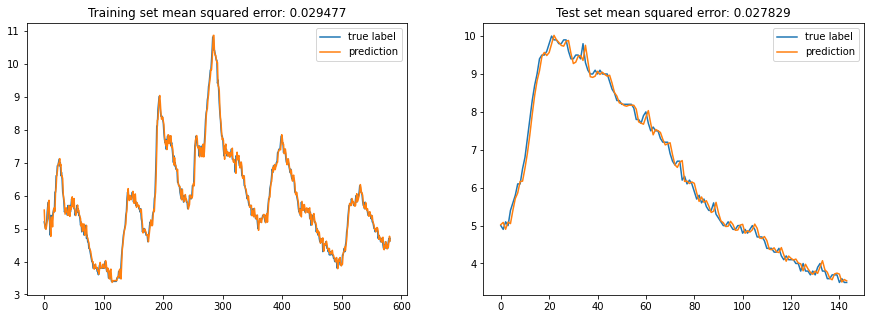

In [57]:
fit_LR_forecast(x_train, y_train, y_mean, y_std)

#### Linear Regression w/ 11 features -- 2020 data included.

Train mse: 0.02100281170538868
Test mse: 0.8366227609216111
Train mae: 0.11199717320137413
Test mae: 0.36541494594812896


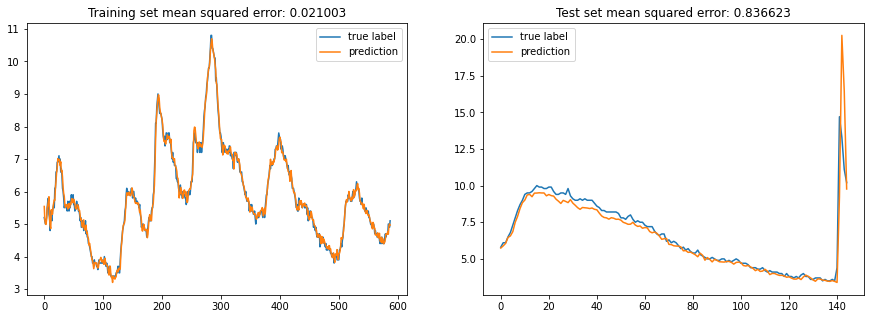

In [58]:
df_base2 = predictor[corr_featrues].dropna()
df_train, df_test = train_test_split(df_base2, test_size = 0.2, shuffle = False)
scaler.fit(df_train.values)
df_train_scaled = pd.DataFrame(scaler.transform(df_train.values), columns=df_train.columns)
df_test_scaled = pd.DataFrame(scaler.transform(df_test.values), columns=df_test.columns)

wg = Window_generator(3,1)
x_train, y_train, col_names = wg.fit_transform(df_train_scaled)
x_test, y_test, _ = wg.fit_transform(df_test_scaled)
y_std = df_train["UNRATE"].std()
y_mean = df_train["UNRATE"].mean()

fit_LR_forecast(x_train, y_train, y_mean, y_std)

#### Linear Regression w/ 1 feature. 2020 data included

Train mse: 0.02944513273681514
Test mse: 0.9377422492704722
Train mae: 0.12976124669384265
Test mae: 0.24973391392578836


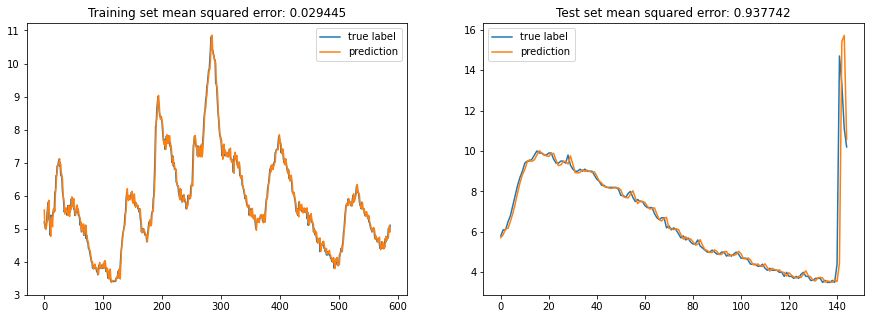

In [61]:
df_base2 = predictor[["UNRATE"]].dropna()
df_train, df_test = train_test_split(df_base2, test_size = 0.2, shuffle = False)
scaler.fit(df_train.values)
df_train_scaled = pd.DataFrame(scaler.transform(df_train.values), columns=df_train.columns)
df_test_scaled = pd.DataFrame(scaler.transform(df_test.values), columns=df_test.columns)

wg = Window_generator(3,1)
x_train, y_train, col_names = wg.fit_transform(df_train_scaled)
x_test, y_test, _ = wg.fit_transform(df_test_scaled)
y_std = df_train["UNRATE"].std()
y_mean = df_train["UNRATE"].mean()

fit_LR_forecast(x_train, y_train, y_mean, y_std)

### Random Forest <a name="rf"></a>

In [62]:
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split as sklearn_train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [63]:
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('Econ_predictors.csv', header=0, index_col=0)

series = series[:-7]
differenced = series.diff(12)
differenced = differenced[12:]
differenced.to_csv('seasonally_adjusted.csv', index = False)

In [64]:
from pandas import DataFrame
series1 = read_csv('seasonally_adjusted.csv', header = 0)
dataframe = DataFrame()
for i in range(12, 0, -1):
    dataframe['t-'+str(i)] = series1.UNRATE.shift(i)
dataframe['t'] = series1.UNRATE
print(dataframe.head(13))
dataframe = dataframe[13:]
dataframe.to_csv('lags_12months_features.csv', index= False)

    t-12  t-11  t-10  t-9  t-8  t-7  t-6  t-5  t-4  t-3  t-2  t-1    t
0    NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN -0.8
1    NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN -0.8 -1.1
2    NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN -0.8 -1.1 -0.2
3    NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN -0.8 -1.1 -0.2  0.0
4    NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN -0.8 -1.1 -0.2  0.0  0.0
5    NaN   NaN   NaN  NaN  NaN  NaN  NaN -0.8 -1.1 -0.2  0.0  0.0  0.4
6    NaN   NaN   NaN  NaN  NaN  NaN -0.8 -1.1 -0.2  0.0  0.0  0.4  0.4
7    NaN   NaN   NaN  NaN  NaN -0.8 -1.1 -0.2  0.0  0.0  0.4  0.4  0.4
8    NaN   NaN   NaN  NaN -0.8 -1.1 -0.2  0.0  0.0  0.4  0.4  0.4  0.0
9    NaN   NaN   NaN -0.8 -1.1 -0.2  0.0  0.0  0.4  0.4  0.4  0.0  0.4
10   NaN   NaN  -0.8 -1.1 -0.2  0.0  0.0  0.4  0.4  0.4  0.0  0.4  0.3
11   NaN  -0.8  -1.1 -0.2  0.0  0.0  0.4  0.4  0.4  0.0  0.4  0.3  1.3
12  -0.8  -1.1  -0.2  0.0  0.0  0.4  0.4  0.4  0.0  0.4  0.3  1.3  1.4


[0.00737162 0.00472529 0.00598045 0.0043243  0.00530289 0.00419353
 0.00482933 0.00496503 0.00436764 0.00597928 0.00812893 0.9398317 ]


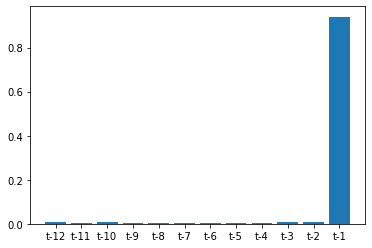

In [65]:
from sklearn.ensemble import RandomForestRegressor
dataframe = read_csv('lags_12months_features.csv', header = 0)
array = dataframe.values
model = RandomForestRegressor(n_estimators=500, random_state=1)
X = array[:, 0:-1]
y = array[:, -1]
model.fit(X, y)
# show importance scores
print(model.feature_importances_)
# plot importance scores
names = dataframe.columns.values[0:-1]
ticks = [i for i in range(len(names))]
pyplot.bar(ticks, model.feature_importances_)
pyplot.xticks(ticks, names)
pyplot.show()

In [66]:
predictors = dataframe[['t-2', 't-3', 't-1']]
target = dataframe[['t']]
x_train, x_cv, y_train, y_cv = sklearn_train_test_split(predictors, target, test_size=0.2, random_state=1)
def scores(i):
    lin = i()
    lin.fit(x_train, y_train)
    y_pred = lin.predict(x_cv)
    lin_r = r2_score(y_cv, y_pred)
    s.append(lin_r)
model = RandomForestRegressor(n_estimators=500, random_state=1)
#Checking the scores by using our function
algos = [LinearRegression, KNeighborsRegressor, RandomForestRegressor, GradientBoostingRegressor, DecisionTreeRegressor]
s = []
for i in algos:
    scores(i)

Let's check the scores of the models that we've made so far.

In [67]:
# Checking the score
models = pd.DataFrame({
    'Method': ['LinearRegression', 'KNeighborsRegression', 'RandomForestRegression',
    'GradientBoostingRegressor', 'DecisionTreeRegression'],
    'Score': [s[0], s[1], s[2], s[3], s[4]]
})
models.sort_values(by="Score", ascending=False)

,Method,Score
0,LinearRegression,0.951646
3,GradientBoostingRegressor,0.949045
1,KNeighborsRegression,0.940459
2,RandomForestRegression,0.939220
4,DecisionTreeRegression,0.922411


As assumed, the Random Forest performed the best on the dataset. We will most likely use it later on. 

#### Random Forest (RF) w/ 1 feature -- 2020 data excluded.

In [68]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
 
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]
 
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = RandomForestRegressor(n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction

	## yhat = model.predict([testX])
	yhat = model.predict(testX)
	return yhat##yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions
 
# load the dataset
values = series.loc[:,'UNRATE'].values.tolist() ## train set
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=3)
# evaluate
# mae, y, yhat = walk_forward_validation(data, 146)

In [69]:
rf_train_val_df, rf_test_df = sklearn_train_test_split(data, test_size = 0.2, shuffle = False)
rf_train_df, rf_val_df = sklearn_train_test_split(rf_train_val_df, test_size = 0.2, shuffle = False)

In [70]:
from sklearn.model_selection import PredefinedSplit
rf_train_X = rf_train_df[:, :-1]
rf_train_y = rf_train_df[:, -1]
rf_val_X = rf_val_df[:, :-1]
rf_val_y = rf_val_df[:, -1]
rf_test_X = rf_test_df[:, :-1]
rf_test_y = rf_test_df[:, -1]
rf_x_train_and_val = np.vstack((rf_train_X, rf_val_X))
print(rf_x_train_and_val.shape)
rf_y_train_and_val = np.vstack((rf_train_y.reshape(467, 1), rf_val_y.reshape(117, 1)))
rf_split = [-1 for _ in range(rf_train_X.shape[0])] + [0 for _ in range(rf_val_X.shape[0])]
rf_cv = PredefinedSplit(rf_split)
for train, test in rf_cv.split():
    print(train[-1])
    print(test[-1])

(584, 3)
466
583


In [71]:
from sklearn.model_selection import GridSearchCV
def rf_evaluate(model, x_train, y_train, x_val, y_val):
    train_pred = model.predict(x_train)
    val_pred = model.predict(x_val)
    print("Train MSE:", mean_squared_error(train_pred, y_train))
    print("Val MSE:" , mean_squared_error(val_pred, y_val))

In [72]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [73]:
# First create the base model to tune
rf_base = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf_base, param_distributions=random_grid,
                            n_iter=100,
                            cv = rf_cv,
                            verbose=0,
                            random_state = 42,
                            n_jobs=-1
)
rf_random.fit(rf_x_train_and_val, rf_y_train_and_val)

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf...
                   param_dis

In [74]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 80,
 'bootstrap': True}

In [75]:
base_model = RandomForestRegressor(n_estimators = 10, random_state=42)
base_model.fit(rf_x_train_and_val, rf_y_train_and_val)
rf_evaluate(base_model, rf_train_X, rf_train_y, rf_val_X, rf_val_y)

Train MSE: 0.01048762132999563
Val MSE: 0.005536555643712076


In [76]:
best_random = rf_random.best_estimator_
rf_evaluate(best_random, rf_train_X, rf_train_y, rf_val_X, rf_val_y)

Train MSE: 0.024388987852199225
Val MSE: 0.010917646491615507


In [77]:
rf_param_grid = {
    'bootstrap': [True],
    'max_depth': [100, 110, 120, 130],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [100, 200, 300, 1000]
}

# Create a base model
rf_nbase = RandomForestRegressor()

# Instantiate the grid search model
rf_grid_search = GridSearchCV(estimator = rf_nbase, param_grid= rf_param_grid,
                                cv = rf_cv, n_jobs = -1, verbose=2)

In [78]:
rf_grid_search.fit(rf_x_train_and_val, rf_y_train_and_val)

Fitting 1 folds for each of 288 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:   47.0s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n...=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_st

In [79]:
rf_grid_search.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 300}

In [80]:
rf_evaluate(rf_grid_search.best_estimator_, rf_train_X, rf_train_y, rf_val_X, rf_val_y)

Train MSE: 0.023141584985654995
Val MSE: 0.010018017901451919


Train mse: 0.02169010610701379
Test mse: 0.03571798678922496
Train mae: 0.10915853081133695
Test mae: 0.14628252210126


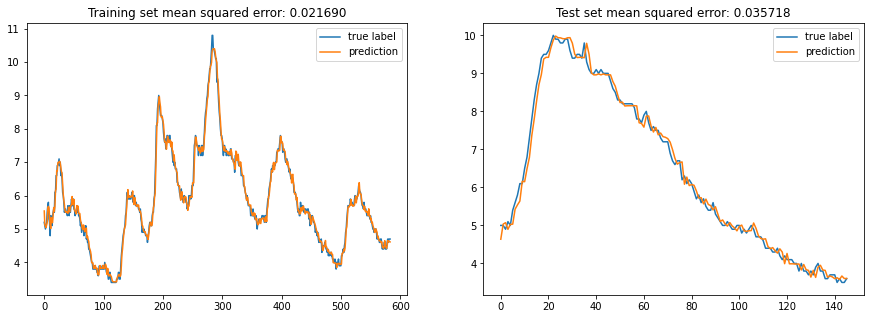

In [81]:
rf_train_prediction = best_random.predict(rf_x_train_and_val)
rf_train_mse = mean_squared_error(rf_train_prediction, rf_y_train_and_val)
rf_test_prediction = best_random.predict(rf_test_X)
rf_test_mse = mean_squared_error(rf_test_prediction, rf_test_y)
print("Train mse:", rf_train_mse)
print("Test mse:" ,rf_test_mse)
rf_train_mae = mean_absolute_error(rf_train_prediction, rf_y_train_and_val)
rf_test_mae = mean_absolute_error(rf_test_prediction, rf_test_y)
print("Train mae:", rf_train_mae)
print("Test mae:", rf_test_mae)
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(rf_y_train_and_val, label = "true label")
axes[0].plot(rf_train_prediction, label = "prediction")
axes[0].legend()
axes[0].set_title("Training set mean squared error: %f" % rf_train_mse)
axes[1].plot(rf_test_y, label = "true label")
axes[1].plot(rf_test_prediction, label = "prediction")
axes[1].legend()
axes[1].set_title("Test set mean squared error: %f" % rf_test_mse)
plt.show()

#### RF w/ 11 features. 2020 data excluded.

In [82]:
rf10_dataset = series[["CUMFNS", "BAAFFM", "CLAIMSx", "HWIURATIO", "UEMPLT5", "UEMP5TO14", "UEMP15OV", "UEMP15T26", "UEMP27OV", "CES1021000001", "UNRATE"]]
rf10_values = rf10_dataset.values.tolist()
rf10_data = series_to_supervised(rf10_values, n_in=3)
## rf10_mae, rf10_y, rf10_yhat = walk_forward_validation(rf10_data, 146)
rf10_data_X = rf10_data[:, :33]
rf10_data_y = rf10_data[:, -1]

In [83]:
rf10_ndata = np.hstack((rf10_data_X, rf10_data_y.reshape(730,1)))
rf10_ndata.shape

(730, 34)

In [84]:
rf10_train_val_df, rf10_test_df = sklearn_train_test_split(rf10_ndata, test_size = 0.2, shuffle = False)
rf10_train_df, rf10_val_df = sklearn_train_test_split(rf10_train_val_df, test_size = 0.2, shuffle = False)

In [85]:
rf10_train_X = rf10_train_df[:, :-1]
rf10_train_y = rf10_train_df[:, -1]
rf10_val_X = rf10_val_df[:, :-1]
rf10_val_y = rf10_val_df[:, -1]
rf10_test_X = rf10_test_df[:, :-1]
rf10_test_y = rf10_test_df[:, -1]
rf10_x_train_and_val = np.vstack((rf10_train_X, rf10_val_X))
print(rf10_x_train_and_val.shape)
rf10_y_train_and_val = np.vstack((rf10_train_y.reshape(467, 1), rf10_val_y.reshape(117, 1)))
rf10_split = [-1 for _ in range(rf10_train_X.shape[0])] + [0 for _ in range(rf10_val_X.shape[0])]

rf10_cv = PredefinedSplit(rf10_split)
for train, test in rf10_cv.split():
    print(train[-1])
    print(test[-1])

(584, 33)
466
583


In [86]:
rf10_base = RandomForestRegressor()
rf10_random = RandomizedSearchCV(estimator = rf10_base, param_distributions=random_grid,
                            n_iter=100,
                            cv = rf_cv,
                            verbose=2,
                            random_state = 42,
                            n_jobs=-1
)
rf10_random.fit(rf10_x_train_and_val, rf10_y_train_and_val)

Fitting 1 folds for each of 100 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf...
                   param_dis

In [87]:
rf10_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 80,
 'bootstrap': True}

In [88]:
base_model_rf10 = RandomForestRegressor(n_estimators = 10, random_state=42)
base_model_rf10.fit(rf10_x_train_and_val, rf10_y_train_and_val)
rf_evaluate(base_model_rf10, rf10_train_X, rf10_train_y, rf10_val_X, rf10_val_y)

Train MSE: 0.0059967880085653145
Val MSE: 0.0024572649572649563


In [89]:
best_random_rf10 = rf10_random.best_estimator_
rf_evaluate(best_random_rf10, rf10_train_X, rf10_train_y, rf10_val_X, rf10_val_y)

Train MSE: 0.012000161505259102
Val MSE: 0.005341487532814484


In [90]:
# Create the parameter grid based on the results of random search
rf10_param_grid = {
    'bootstrap': [True],
    'max_depth': [70,80, 100, 120],
    'max_features': [2, 3, 4, 5],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [1200, 1400, 1600, 1800]
}

# Create a base model
rf10_nbase = RandomForestRegressor()

# Instantiate the grid search model
rf10_grid_search = GridSearchCV(estimator = rf10_nbase, param_grid= rf10_param_grid,
                                cv = rf_cv, n_jobs = -1, verbose=2)

In [91]:
rf10_grid_search.fit(rf10_x_train_and_val, rf10_y_train_and_val)

Fitting 1 folds for each of 576 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed: 12.7min finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n...,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=F

In [92]:
rf10_grid_search.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 1600}

In [93]:
rf10_grid_best = rf10_grid_search.best_estimator_
rf_evaluate(rf10_grid_best, rf10_train_X, rf10_train_y, rf10_val_X, rf10_val_y)

Train MSE: 0.007992728725848493
Val MSE: 0.0031082847067097816


Train mse: 0.0070141671672196764
Test mse: 0.18160440556609808
Train mae: 0.0590437346537322
Test mae: 0.3702400351052107


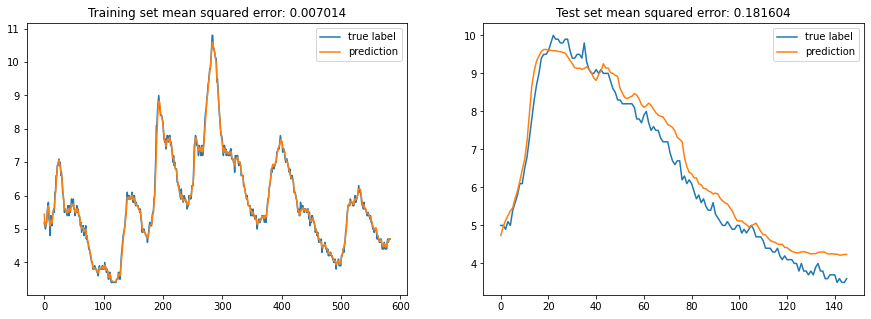

In [94]:
rf10_train_prediction = rf10_grid_best.predict(rf10_x_train_and_val)
rf10_train_mse = mean_squared_error(rf10_train_prediction, rf10_y_train_and_val)
rf10_test_prediction = rf10_grid_best.predict(rf10_test_X)
rf10_test_mse = mean_squared_error(rf10_test_prediction, rf10_test_y)
print("Train mse:", rf10_train_mse)
print("Test mse:" ,rf10_test_mse)
rf10_train_mae = mean_absolute_error(rf10_train_prediction, rf10_y_train_and_val)
rf10_test_mae = mean_absolute_error(rf10_test_prediction, rf10_test_y)
print("Train mae:", rf10_train_mae)
print("Test mae:", rf10_test_mae)
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(rf10_y_train_and_val, label = "true label")
axes[0].plot(rf10_train_prediction, label = "prediction")
axes[0].legend()
axes[0].set_title("Training set mean squared error: %f" % rf10_train_mse)
axes[1].plot(rf10_test_y, label = "true label")
axes[1].plot(rf10_test_prediction, label = "prediction")
axes[1].legend()
axes[1].set_title("Test set mean squared error: %f" % rf10_test_mse)
plt.show()

### XGBoost w/ 1 feature -- 2020 data excluded. <a name="xg"></a>

In [95]:
import xgboost
model = xgboost.XGBRegressor()

In [96]:
values = series.loc[:,'UNRATE'].values.tolist()
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=3) # three months to predict one month

In [97]:
xg_train_val_df, xg_test_df = sklearn_train_test_split(data, test_size=0.2, shuffle = False)
xg_train_df, xg_val_df = sklearn_train_test_split(xg_train_val_df, test_size=0.2, shuffle = False)

from xgboost import XGBRegressor
xg_trainX = xg_train_df[:, :-1]
xg_trainy = xg_train_df[:, -1]
xg_valX = xg_val_df[:, :-1]
xg_valy = xg_val_df[:, -1]
xg_testX = xg_test_df[:, :-1]
xg_testy = xg_test_df[:, -1]
xg_x_train_and_val = np.vstack((xg_trainX, xg_valX))
print(xg_x_train_and_val.shape)
xg_y_train_and_val = np.vstack((xg_trainy.reshape(467, 1), xg_valy.reshape(117, 1)))

split = [-1 for _ in range(xg_trainX.shape[0])] + [0 for _ in range(xg_valX.shape[0])]
cv = PredefinedSplit(split)
for train,test in cv.split():
    print(train[-1])
    print(test[-1])

(584, 3)
466
583


In [98]:
from sklearn.model_selection import GridSearchCV
def xgb_model_fit(regressor, x_train, y_train, x_val, y_val):
    regressor.fit(x_train, y_train, eval_metric = "rmse")
    train_pred = regressor.predict(x_train)
    val_pred = regressor.predict(x_val)
    print("Train MSE:", mean_squared_error(train_pred, y_train))
    print("Val MSE:", mean_squared_error(val_pred, y_val))

In [99]:
xgb_base = XGBRegressor(learning_rate=0.1,
                         n_estimators=50,
                         max_depth=7,
                         min_child_weight=1,
                         gamma=0,
                         subsample=0.7,
                         colsample_bytree=0.9,
                         objective= 'reg:squarederror',
                         nthread=-1,
                        )
print("Base xgb :")
xgb_model_fit(xgb_base, xg_trainX, xg_trainy, xg_valX, xg_valy)

Base xgb :
Train MSE: 0.022114542656688507
Val MSE: 0.02395791293776012


In [100]:
xg_param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
xg_gsearch1 = GridSearchCV(estimator = xgb_base, param_grid = xg_param_test1, scoring='neg_mean_squared_error', n_jobs=4, cv=cv)
xg_gsearch1.fit(xg_x_train_and_val, xg_y_train_and_val)
print("Best score:", xg_gsearch1.best_score_)
print("Best params:", xg_gsearch1.best_params_)
# print("result:", gsearch1.cv_results_)
print("\n")
xgb_base.set_params(**xg_gsearch1.best_params_)
print("Xgb after 1st tune:")
xgb_model_fit(xgb_base, xg_trainX, xg_trainy, xg_valX, xg_valy)

Best score: -0.02263286821908749
Best params: {'max_depth': 7, 'min_child_weight': 5}


Xgb after 1st tune:
Train MSE: 0.025502179210349453
Val MSE: 0.02263286821908749


In [101]:
xg_param_test2 = {
 'max_depth':[6,7,8,9]
}
xg_gsearch2 = GridSearchCV(estimator = xgb_base, param_grid = xg_param_test2, scoring='neg_mean_squared_error', n_jobs=4, cv=cv)
xg_gsearch2.fit(xg_x_train_and_val, xg_y_train_and_val)
print("Best score:", xg_gsearch2.best_score_)
print("Best params:", xg_gsearch2.best_params_)
# print("result:", gsearch2.cv_results_)
print("\n")
xgb_base.set_params(**xg_gsearch2.best_params_)
print("Xgb after 2nd tune:")
xgb_model_fit(xgb_base, xg_trainX, xg_trainy, xg_valX, xg_valy)

Best score: -0.02263286821908749
Best params: {'max_depth': 7}


Xgb after 2nd tune:
Train MSE: 0.025502179210349453
Val MSE: 0.02263286821908749


In [102]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
xg_gsearch3 = GridSearchCV(estimator = xgb_base, param_grid = param_test3, scoring='neg_mean_squared_error', n_jobs=4, cv=cv)
xg_gsearch3.fit(xg_x_train_and_val, xg_y_train_and_val)
print("Best score:", xg_gsearch3.best_score_)
print("Best params:", xg_gsearch3.best_params_)
# print("result:", gsearch3.cv_results_)
print("\n")
xgb_base.set_params(**xg_gsearch3.best_params_)
print("Xgb after 3rd tune:")
xgb_model_fit(xgb_base, xg_trainX, xg_trainy, xg_valX, xg_valy)

Best score: -0.02263286821908749
Best params: {'gamma': 0.0}


Xgb after 3rd tune:
Train MSE: 0.025502179210349453
Val MSE: 0.02263286821908749


In [103]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
xg_gsearch4 = GridSearchCV(estimator = xgb_base, param_grid = param_test4, scoring='neg_mean_squared_error', n_jobs=4, cv=cv)
xg_gsearch4.fit(xg_x_train_and_val, xg_y_train_and_val)
print("Best score:", xg_gsearch4.best_score_)
print("Best params:", xg_gsearch4.best_params_)
# print("result:", gsearch4.cv_results_)
print("\n")
xgb_base.set_params(**xg_gsearch4.best_params_)
print("Xgb after 4th tune:")
xgb_model_fit(xgb_base, xg_trainX, xg_trainy, xg_valX, xg_valy)

Best score: -0.020112826829199484
Best params: {'colsample_bytree': 0.7, 'subsample': 0.9}


Xgb after 4th tune:
Train MSE: 0.023852028593381792
Val MSE: 0.020112826829199484


In [104]:
param_test5 = {
 'reg_alpha':[1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100]
}
xg_gsearch5 = GridSearchCV(estimator = xgb_base, param_grid = param_test5, scoring='neg_mean_squared_error', n_jobs=4, cv=cv)
xg_gsearch5.fit(xg_x_train_and_val, xg_y_train_and_val)
print("Best score:", xg_gsearch5.best_score_)
print("Best params:", xg_gsearch5.best_params_)
# print("result:", gsearch5.cv_results_)
print("\n")
xgb_base.set_params(**xg_gsearch5.best_params_)
print("Xgb after 5th tune:")
xgb_model_fit(xgb_base, xg_trainX, xg_trainy, xg_valX, xg_valy)

Best score: -0.01963530559464601
Best params: {'reg_alpha': 1}


Xgb after 5th tune:
Train MSE: 0.03560350427304188
Val MSE: 0.01963530559464601


In [105]:
param_test6 = {
 'reg_alpha':[i/1000 for i in range(5)] 
}
xg_gsearch6 = GridSearchCV(estimator = xgb_base, param_grid = param_test6, scoring='neg_mean_squared_error', n_jobs=4, cv=cv)
xg_gsearch6.fit(xg_x_train_and_val, xg_y_train_and_val)
print("Best score:", xg_gsearch6.best_score_)
print("Best params:", xg_gsearch6.best_params_)
# print("result:", gsearch6.cv_results_)
print("\n")
xgb_base.set_params(**xg_gsearch6.best_params_)
print("Xgb after 6th tune:")
xgb_model_fit(xgb_base, xg_trainX, xg_trainy, xg_valX, xg_valy)

Best score: -0.020112826829199484
Best params: {'reg_alpha': 0.0}


Xgb after 6th tune:
Train MSE: 0.023852028593381792
Val MSE: 0.020112826829199484


Train mse: 0.022958343063070357
Test mse: 0.0506462166762053
Train mae: 0.11330347167302483
Test mae: 0.1716987146090154


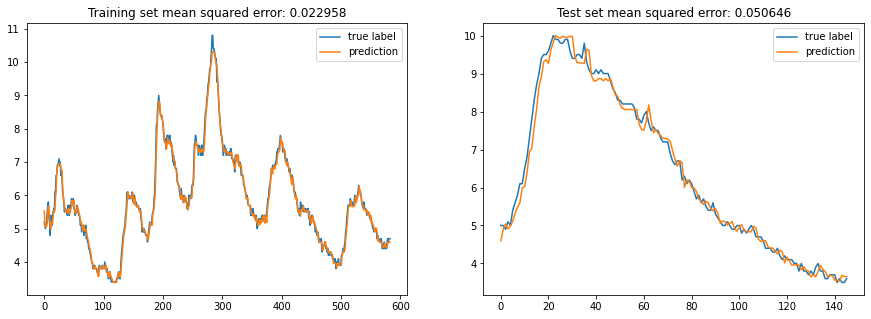

In [106]:
xgb_base.fit(xg_x_train_and_val, xg_y_train_and_val)
xgb_train_prediction = xgb_base.predict(xg_x_train_and_val)
xgb_train_mse = mean_squared_error(xgb_train_prediction, xg_y_train_and_val)
xgb_test_prediction = xgb_base.predict(xg_testX)
xgb_test_mse = mean_squared_error(xgb_test_prediction, xg_testy)
print("Train mse:" , xgb_train_mse)
print("Test mse:", xgb_test_mse)
xgb_test_mae = mean_absolute_error(xgb_test_prediction, xg_testy)
xgb_train_mae = mean_absolute_error(xgb_train_prediction, xg_y_train_and_val)
print("Train mae:", xgb_train_mae)
print("Test mae:", xgb_test_mae)
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(xg_y_train_and_val, label = "true label")
axes[0].plot(xgb_train_prediction, label = "prediction")
axes[0].legend()
axes[0].set_title("Training set mean squared error: %f" % xgb_train_mse)
axes[1].plot(xg_testy, label = "true label")
axes[1].plot(xgb_test_prediction, label = "prediction")
axes[1].legend()
axes[1].set_title("Test set mean squared error: %f" % xgb_test_mse)
plt.show()

#### XGBoost w/ 11 features -- 2020 data excluded

In [107]:
from sklearn.model_selection import train_test_split
ten_features = data_2020_removed[corr_featrues]
wg_xg10 = Window_generator(input_window_length=3, label_width=1, shift = 1)
train_val_df, test_df = train_test_split(ten_features, test_size=0.2, shuffle = False)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, shuffle = False)
wg_xg10.fit(train_df)
x_train_xg10, y_train_xg10, _ = wg_xg10.transform(train_df)
wg_xg10.fit(val_df)
x_val_xg10, y_val_xg10, _ = wg_xg10.transform(val_df)
wg_xg10.fit(test_df)
x_test_xg10, y_test_xg10, _ = wg_xg10.transform(test_df)

def xgb_model_fit(regressor, x_train, y_train, x_val, y_val):
    regressor.fit(x_train, y_train, eval_metric = "rmse")
    train_pred = regressor.predict(x_train)
    val_pred = regressor.predict(x_val)
    print("Train MSE:", mean_squared_error(train_pred, y_train))
    print("Val MSE:", mean_squared_error(val_pred, y_val))

In [108]:
from sklearn.model_selection import PredefinedSplit
x_train_and_val = np.vstack((x_train_xg10, x_val_xg10))
print(x_train_and_val.shape)
y_train_and_val = np.vstack((y_train_xg10, y_val_xg10))
split = [-1 for _ in range(x_train_xg10.shape[0])] + [0 for _ in range(x_val_xg10.shape[0])]
cv = PredefinedSplit(split)
for train,test in cv.split():
    print(train[-1])
    print(test[-1])

(579, 33)
464
578


In [109]:
xgb_base = XGBRegressor(learning_rate=0.1,
                         n_estimators=50,
                         max_depth=5,
                         min_child_weight=1,
                         gamma=0,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         objective= 'reg:squarederror',
                         nthread=-1,
                        )
print("Base xgb :")
xgb_model_fit(xgb_base, x_train_xg10, y_train_xg10, x_val_xg10, y_val_xg10)

Base xgb :
Train MSE: 0.010143238372652665
Val MSE: 0.04218235061354653


In [110]:
# Step 0: n_estimator and learning rate
param_test0 = {
 'n_estimator':[40, 50, 60, 70, 80],
 'learning_rate':[0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
}
gsearch0 = GridSearchCV(estimator = xgb_base, param_grid = param_test0, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)
gsearch0.fit(x_train_and_val, y_train_and_val)
print("Best score:", gsearch0.best_score_)
print("Best params:", gsearch0.best_params_)
# print("result:", gsearch0.cv_results_)
print("\n")
xgb_base.set_params(**gsearch0.best_params_)
print("Xgb after oth tune:")
xgb_model_fit(xgb_base, x_train_xg10, y_train_xg10, x_val_xg10, y_val_xg10)

[16:32:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Best score: -0.03633733025423226
Best params: {'learning_rate': 0.09, 'n_estimator': 40}


Xgb after oth tune:
[16:32:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Train MSE: 0.013419181864448702
Val MSE: 0.03633733025423226


In [111]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb_base, param_grid = param_test1, scoring='neg_mean_squared_error', n_jobs=4, cv=cv)
gsearch1.fit(x_train_and_val, y_train_and_val)
print("Best score:", gsearch1.best_score_)
print("Best params:", gsearch1.best_params_)
# print("result:", gsearch1.cv_results_)
print("\n")
xgb_base.set_params(**gsearch1.best_params_)
print("Xgb after 1st tune:")
xgb_model_fit(xgb_base, x_train_xg10, y_train_xg10, x_val_xg10, y_val_xg10)

[16:32:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Best score: -0.03533803883906498
Best params: {'max_depth': 9, 'min_child_weight': 1}


Xgb after 1st tune:
[16:32:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Train MSE: 0.009552947609556323
Val MSE: 0.03533803883906498


In [112]:
param_test2 = {
 'max_depth':[5,6,7,8,9]
}
gsearch2 = GridSearchCV(estimator = xgb_base, param_grid = param_test2, scoring='neg_mean_squared_error', n_jobs=4, cv=cv)
gsearch2.fit(x_train_and_val, y_train_and_val)
print("Best score:", gsearch2.best_score_)
print("Best params:", gsearch2.best_params_)
# print("result:", gsearch2.cv_results_)
print("\n")
xgb_base.set_params(**gsearch2.best_params_)
print("Xgb after 2nd tune:")
xgb_model_fit(xgb_base, x_train_xg10, y_train_xg10, x_val_xg10, y_val_xg10)

[16:32:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Best score: -0.03533803883906498
Best params: {'max_depth': 9}


Xgb after 2nd tune:
[16:32:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Train MSE: 0.009552947609556323
Val MSE: 0.03533803883906498


<a name="exploration"></a>

In [113]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = xgb_base, param_grid = param_test3, scoring='neg_mean_squared_error', n_jobs=4, cv=cv)
gsearch3.fit(x_train_and_val, y_train_and_val)
print("Best score:", gsearch3.best_score_)
print("Best params:", gsearch3.best_params_)
# print("result:", gsearch3.cv_results_)
print("\n")
xgb_base.set_params(**gsearch3.best_params_)
print("Xgb after 3rd tune:")
xgb_model_fit

[16:34:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Best score: -0.03533803883906498
Best params: {'gamma': 0.0}


Xgb after 3rd tune:


<function __main__.xgb_model_fit(regressor, x_train, y_train, x_val, y_val)>

In [114]:
param_test4 = {
 'subsample':[i/10.0 for i in range(4,10)],
 'colsample_bytree':[i/10.0 for i in range(4,10)]
}
gsearch4 = GridSearchCV(estimator = xgb_base, param_grid = param_test4, scoring='neg_mean_squared_error', n_jobs=4, cv=cv)
gsearch4.fit(x_train_and_val, y_train_and_val)
print("Best score:", gsearch4.best_score_)
print("Best params:", gsearch4.best_params_)
# print("result:", gsearch4.cv_results_)
print("\n")
xgb_base.set_params(**gsearch4.best_params_)
print("Xgb after 4th tune:")
xgb_model_fit(xgb_base, x_train_xg10, y_train_xg10, x_val_xg10, y_val_xg10)

[16:35:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Best score: -0.027471356789470328
Best params: {'colsample_bytree': 0.6, 'subsample': 0.7}


Xgb after 4th tune:
[16:35:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Train MSE: 0.011372810125110338
Val MSE: 0.027471356789470328


In [115]:
param_test5 = {
 'reg_alpha':[1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100]
}
gsearch5 = GridSearchCV(estimator = xgb_base, param_grid = param_test5, scoring='neg_mean_squared_error', n_jobs=4, cv=cv)
gsearch5.fit(x_train_and_val, y_train_and_val)
print("Best score:", gsearch5.best_score_)
print("Best params:", gsearch5.best_params_)
# print("result:", gsearch5.cv_results_)
print("\n")
xgb_base.set_params(**gsearch5.best_params_)
print("Xgb after 5th tune:")
xgb_model_fit(xgb_base, x_train_xg10, y_train_xg10, x_val_xg10, y_val_xg10)

[16:35:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Best score: -0.026796634175261076
Best params: {'reg_alpha': 0.1}


Xgb after 5th tune:
[16:35:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Train MSE: 0.01407126102964622
Val MSE: 0.026796634175261076


In [116]:
param_test6 = {
 'reg_alpha':[i/10 for i in range(10)] + [i/100 for i in range(10)]
}
gsearch6 = GridSearchCV(estimator = xgb_base, param_grid = param_test6, scoring='neg_mean_squared_error', n_jobs=4, cv=cv)
gsearch6.fit(x_train_and_val, y_train_and_val)
print("Best score:", gsearch6.best_score_)
print("Best params:", gsearch6.best_params_)
# print("result:", gsearch6.cv_results_)
print("\n")
xgb_base.set_params(**gsearch6.best_params_)
print("Xgb after 6th tune:")
xgb_model_fit(xgb_base, x_train_xg10, y_train_xg10, x_val_xg10, y_val_xg10)

[16:35:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Best score: -0.021688162046195125
Best params: {'reg_alpha': 0.5}


Xgb after 6th tune:
[16:35:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Train MSE: 0.02111618922315785
Val MSE: 0.021688162046195125


[16:35:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Train mse: 0.022034397506662355
Test mse: 0.03464855229153388
Train mae: 0.10450112312070786
Test mae: 0.15166556305355494


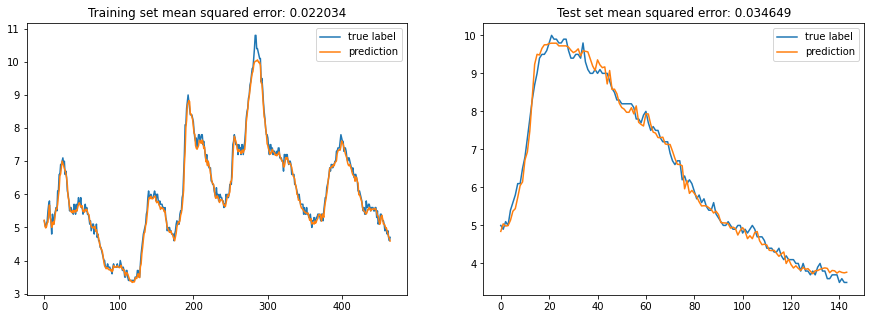

In [117]:
wg_xg10.fit(train_val_df)
x_train_full, y_train_full, columns_ = wg_xg10.transform(train_val_df)
xgb_base.fit(x_train_full, y_train_full)
train_prediction = xgb_base.predict(x_train_xg10)
train_mse = mean_squared_error(train_prediction , y_train_xg10)
test_prediction = xgb_base.predict(x_test_xg10)
test_mse = mean_squared_error(test_prediction, y_test_xg10)
print("Train mse:", train_mse)
print("Test mse:", test_mse)
test_mae = mean_absolute_error(test_prediction, y_test_xg10)
train_mae = mean_absolute_error(train_prediction , y_train_xg10)
print("Train mae:", train_mae)
print("Test mae:", test_mae)
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(y_train_xg10, label = "true label")
axes[0].plot(train_prediction, label = "prediction")
axes[0].legend()
axes[0].set_title("Training set mean squared error: %f" % train_mse)
axes[1].plot(y_test_xg10, label = "true label")
axes[1].plot(test_prediction, label = "prediction")
axes[1].legend()
axes[1].set_title("Test set mean squared error: %f" % test_mse)
plt.show()

### ARIMA<a name="arima"></a>

<br>
Autoregressive Integrated Moving Average

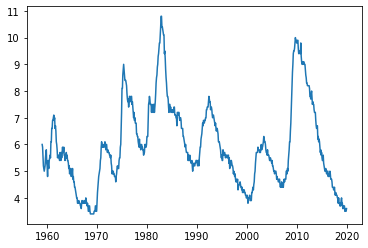

In [120]:
predictors = pd.read_csv("Econ_predictors.csv")
predictors.sasdate = pd.to_datetime(predictors.sasdate, infer_datetime_format=True)
time_series = predictors[["sasdate", "UNRATE"]][:-7]
plt.plot(time_series["sasdate"], time_series["UNRATE"])

In [121]:
time_series["year"] = [d.year for d in time_series.sasdate]
time_series["month"] = [d.month for d in time_series.sasdate]

<Figure size 1280x960 with 0 Axes>

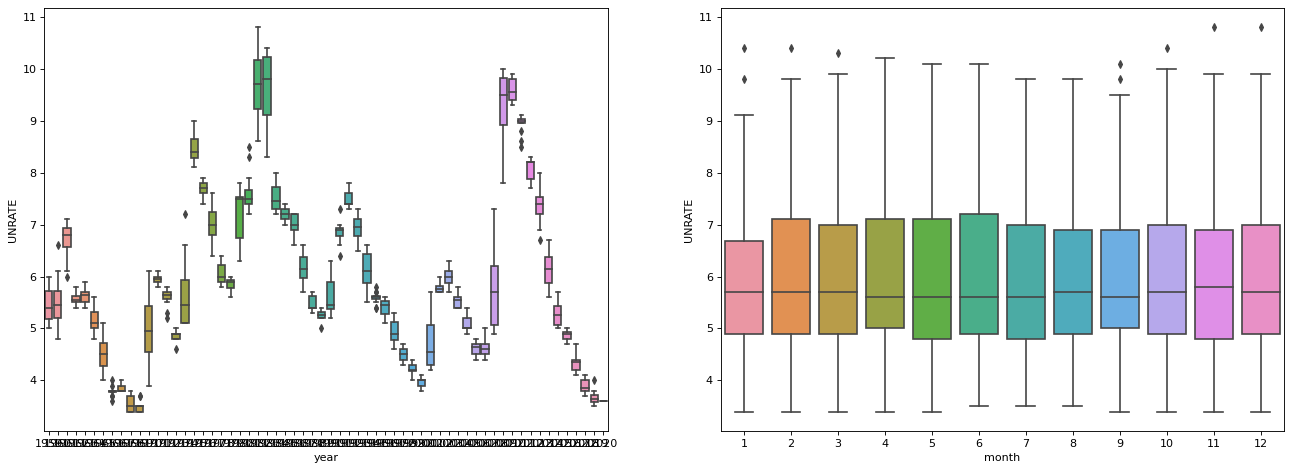

In [122]:
plt.figure(figsize=(16,12), dpi= 80)
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot("year", "UNRATE", data = time_series, ax=axes[0])
sns.boxplot("month", "UNRATE", data = time_series, ax=axes[1])

Looking at the above figures, there is no seasonality observed.

In [125]:
import statsmodels
import statsmodels.formula.api as smf   
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 3)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

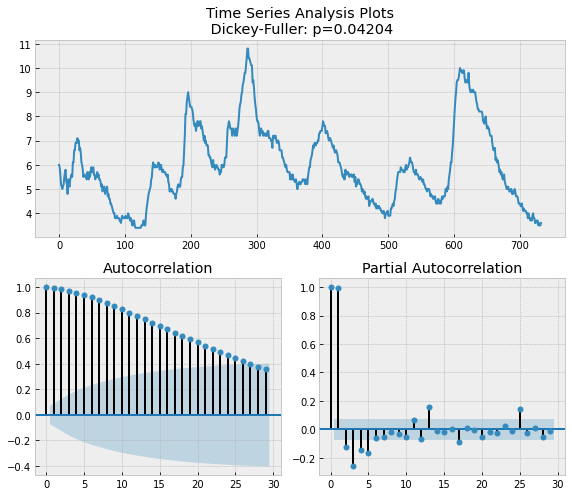

In [126]:
time_series = time_series['UNRATE']
x_train, x_test = train_test_split(time_series, test_size = 0.2, shuffle = False)
tsplot(time_series)

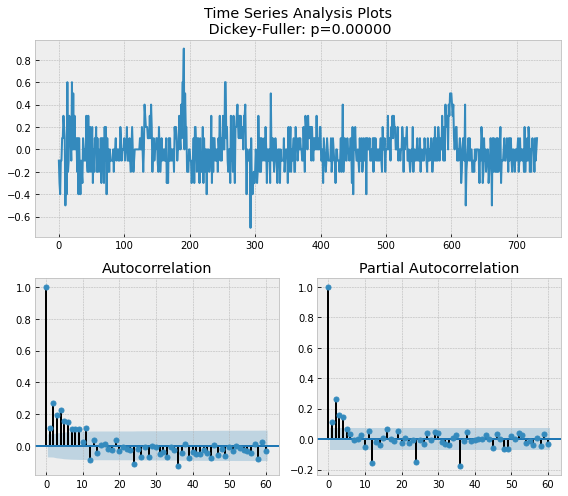

In [127]:
def diff(series, diff_length):
    if type(series) != pd.Series:
        series = pd.Series(series)
    return pd.Series(series[diff_length:].values - series[:-diff_length].values)
diff_12m = diff(time_series, 1)
tsplot(diff_12m, lags=60)

In [128]:
from itertools import product
import tqdm
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

def fitSARIMA(series, parameters_list, s):
    results = []
    best_aic = float("inf")

    for param in tqdm.tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(series, order=(param[0], param[4], param[1]), 
                                            seasonal_order=(param[2], param[5], param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table
p = range(12)
q = range(12)
P = range(1)
Q = range(1)
d = range(1, 2)
D = range(1)
param_list = list(product(p, q, P, Q, d, D))

In [131]:
result_table = fitSARIMA(x_train, param_list, s = 12)
print(result_table)


              parameters         aic
0     (5, 9, 0, 0, 1, 0) -436.097133
1     (6, 9, 0, 0, 1, 0) -434.643798
2    (11, 9, 0, 0, 1, 0) -433.981347
3     (4, 9, 0, 0, 1, 0) -433.627375
4    (5, 10, 0, 0, 1, 0) -433.331212
..                   ...         ...
139   (0, 3, 0, 0, 1, 0) -390.014270
140   (0, 2, 0, 0, 1, 0) -380.716844
141   (1, 0, 0, 0, 1, 0) -357.225921
142   (0, 1, 0, 0, 1, 0) -356.216901
143   (0, 0, 0, 0, 1, 0) -356.129632

[144 rows x 2 columns]


In [132]:
p, q, P, Q, d, D = result_table.parameters[0]
best_model=sm.tsa.statespace.SARIMAX(x_train, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, 12)).fit(disp=-1)
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 UNRATE   No. Observations:                  586
Model:               SARIMAX(5, 1, 9)   Log Likelihood                 233.049
Date:                Sun, 27 Dec 2020   AIC                           -436.097
Time:                        18:16:51   BIC                           -370.523
Sample:                             0   HQIC                          -410.542
                                - 586                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5458      0.196     -2.787      0.005      -0.930      -0.162
ar.L2          0.8290      0.095      8.725      0.000       0.643       1.015
ar.L3          0.2658      0.241      1.101      0.2

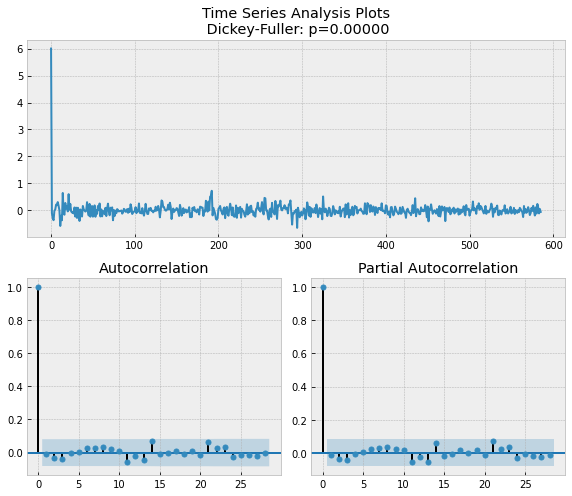

In [133]:
tsplot(best_model.resid[:])

In [134]:
def plotSARIMA(x_train, x_test, model, n_steps, s = 12, d = 1):
    train_predict = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model due to the differentiating
    train_error = mean_squared_error(train_predict[d:], x_train[d:])
    print("Train error:", train_error)
    # forecasting on n_steps forward 
    forecast = model.predict(start = x_train.shape[0], end = x_train.shape[0] + x_test.shape[0] - 1)
    # calculate error, again having shifted on s+d steps from the beginning
    test_error = mean_squared_error(forecast, x_test)
    print("Test error:", test_error)
    
    plt.figure(figsize=(15, 7))
    plt.title("Mean Squared Error: {0:.2f}".format(test_error))
    plt.plot(x_train, color = 'blue', label = 'actual')
    plt.plot(x_test, color = 'blue')
    plt.plot(train_predict, color = 'r', label = "train predict")
    plt.plot(forecast, color = 'orange', label = "forecast")
    plt.legend()
    plt.grid(True);

Train error: 0.026519653550726014
Test error: 7.177373942242007


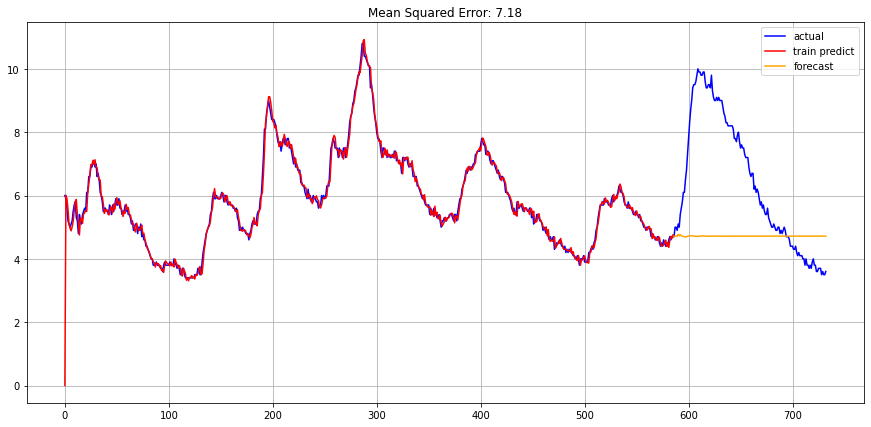

In [135]:
plotSARIMA(x_train, x_test, best_model, 0)
